# Things to try to fix this

- Try fitting some fake `batman` curves
    - This worked!!
    - It might mean that we just need better initial radius values
    - Update: NOPE
- Outlier rejection using `remove_outliers` - make sure it isn't masking the transits
    - Perhaps could just pull out the data from around the transits rather than the whole thing
- Check if the basic literature values line up properly

# Try doing everything for Kepler-444

In [62]:
import exoplanet as xo
import lightkurve as lk
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time

%config InlineBackend.figure_format = "retina"

# Get the data

Get all Kepler data on Kepler-444 using Lightkurve. To start I get the target pixel files, then convert them to lightcurves using PLD.

In [63]:
search_results = lk.search_targetpixelfile("Kepler-444", mission="Kepler", exptime=1800)
search_results

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 00,2009,Kepler,1800,kplr006278762,0.0
1,Kepler Quarter 01,2009,Kepler,1800,kplr006278762,0.0
2,Kepler Quarter 02,2009,Kepler,1800,kplr006278762,0.0
3,Kepler Quarter 03,2009,Kepler,1800,kplr006278762,0.0
4,Kepler Quarter 04,2010,Kepler,1800,kplr006278762,0.0
5,Kepler Quarter 05,2010,Kepler,1800,kplr006278762,0.0
6,Kepler Quarter 06,2010,Kepler,1800,kplr006278762,0.0
7,Kepler Quarter 07,2010,Kepler,1800,kplr006278762,0.0
8,Kepler Quarter 08,2011,Kepler,1800,kplr006278762,0.0


In [64]:
tpfs = search_results.download_all()#download_dir="/epyc/ssd/users/tomwagg/lk_cache/")

KeyboardInterrupt: 

In [ ]:
lcs = [tpf.to_lightcurve(method="pld") for tpf in tpfs]
lcc = lk.LightCurveCollection(lightcurves=lcs)

Now let's look at the separate light curves, coloured by quarter

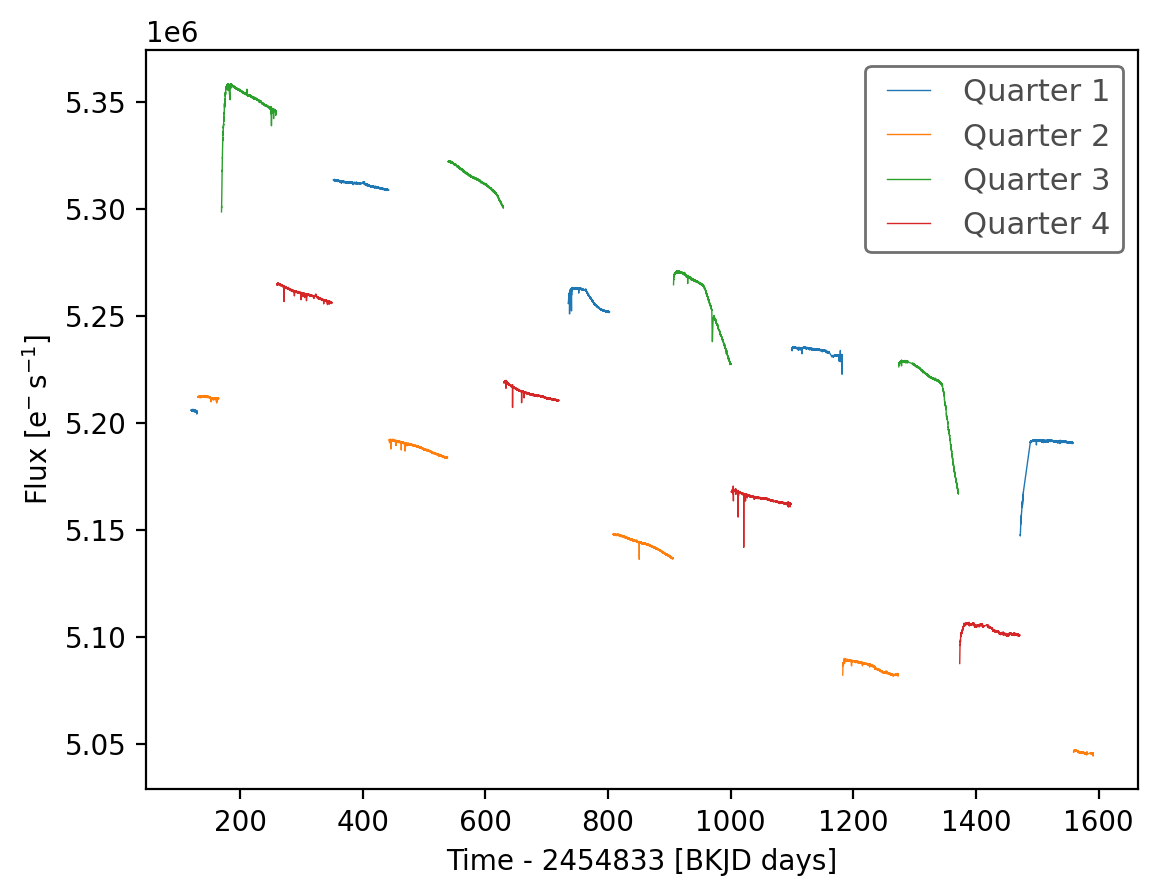

In [ ]:
fig, ax = plt.subplots()
for i in range(len(lcs)):
    lcs[i].plot(ax=ax, label=f"Quarter {lcs[i].QUARTER % 4 + 1}" if i < 4 else None, color=plt.get_cmap("tab10")(lcs[i].QUARTER % 4))

Now we can use LightKurve to stitch together the lightcurves from different quarters and flatten them.

In [111]:
flat_lc = lcc.stitch().flatten()

# Remove outliers
Next we can remove outliers from the data, this is important but we have to be careful to avoid the transits.

In [112]:
_, outlier_mask = flat_lc.remove_outliers(return_mask=True)

We can see that this looks pretty good so far, but we aren't checking for transits

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

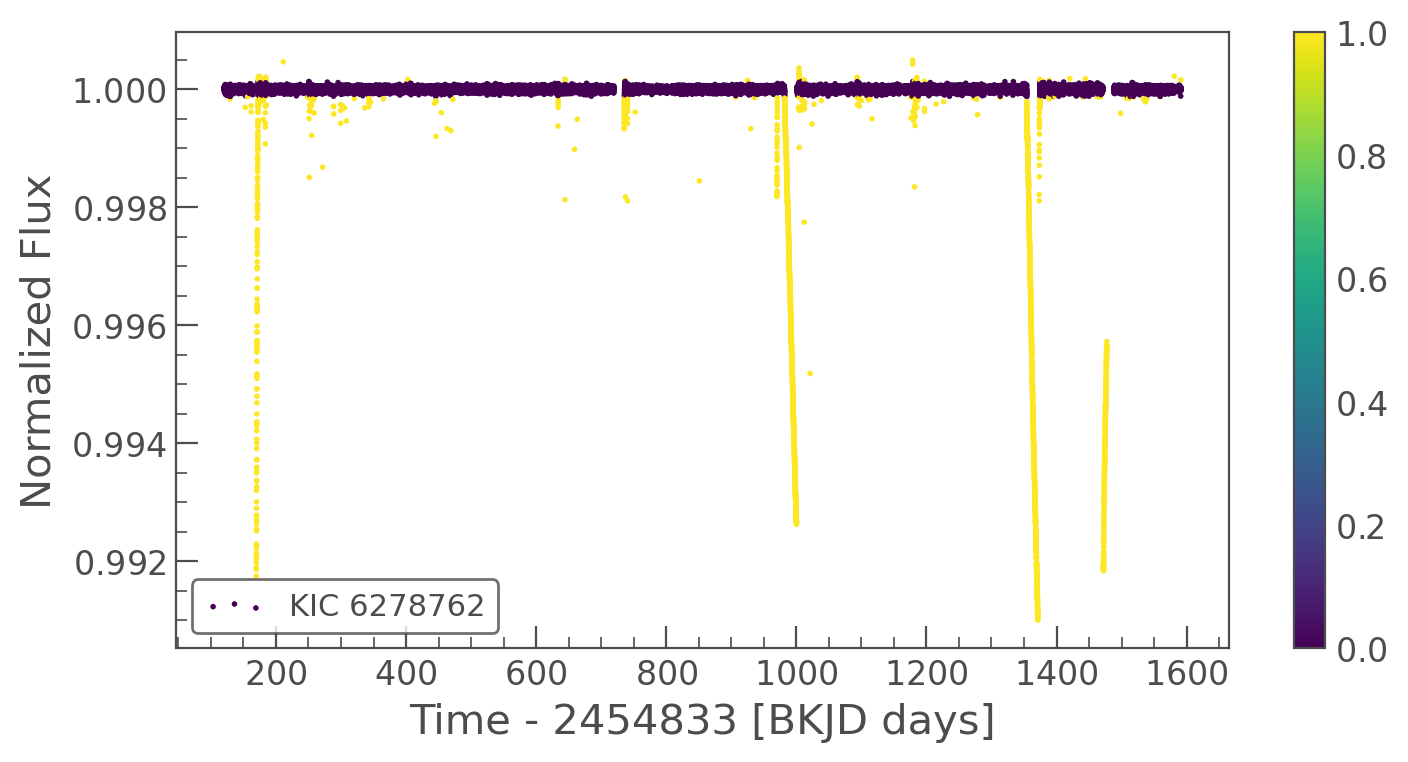

In [113]:
flat_lc.scatter(c=outlier_mask)

In [117]:
kepler_start = 2454833 * u.day
planets = ['b', 'c', 'd', 'e', 'f']
planet_parameters = {
    "b": {
        "period": 3.6001053 * u.day,
        "t0": Time(2454966.2599 * u.day, format="jd"),
        "radius": 0.00491,
        "t14":  2.4741 * u.hour
    },
    "c" : {
        "period": 4.5458841 * u.day,
        "t0": Time(2454964.5220 * u.day, format="jd"),
        "radius": 0.00605,
        "t14": 2.1498 * u.hour
    },
    'd' : {
        "period": 6.189392 * u.day,
        "t0": Time(2454967.7869 * u.day, format="jd"),
        "radius": 0.00644,
        "t14":  2.5895  * u.hour
    },
    'e' : {
        "period": 7.743493 * u.day,
        "t0": Time(2454968.0927 * u.day, format="jd"),
        "radius": 0.00664,
        "t14":  3.1263  * u.hour
    },
    'f' : {
        "period": 9.740486 * u.day,
        "t0": Time(2454967.8791 * u.day, format="jd"),
        "radius": 0.00903,
        "t14":  2.0354  * u.hour
    },
}

star_parameters = {
    "rho": 2.3237462 * u.g / u.cm**3
}

In [131]:
total_in_transit = np.zeros(len(flat_lc.time))
for p in "bcdef":
    phase = (flat_lc.time - planet_parameters[p]["t0"]).to(u.day).value % planet_parameters[p]["period"].value
    # order = np.argsort(((flat_lc.time.bkjd - t0) + (p - p/2)) % p - (p - p/2))
    half_transit = 0.5 * planet_parameters[p]["t14"].to(u.day).value
    in_transit = (phase < half_transit) | (phase > planet_parameters[p]["period"].value - half_transit)
    total_in_transit += in_transit.astype(int)
any_in_transit = total_in_transit > 0

In [137]:
lc = flat_lc[~(outlier_mask & (~any_in_transit))]

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

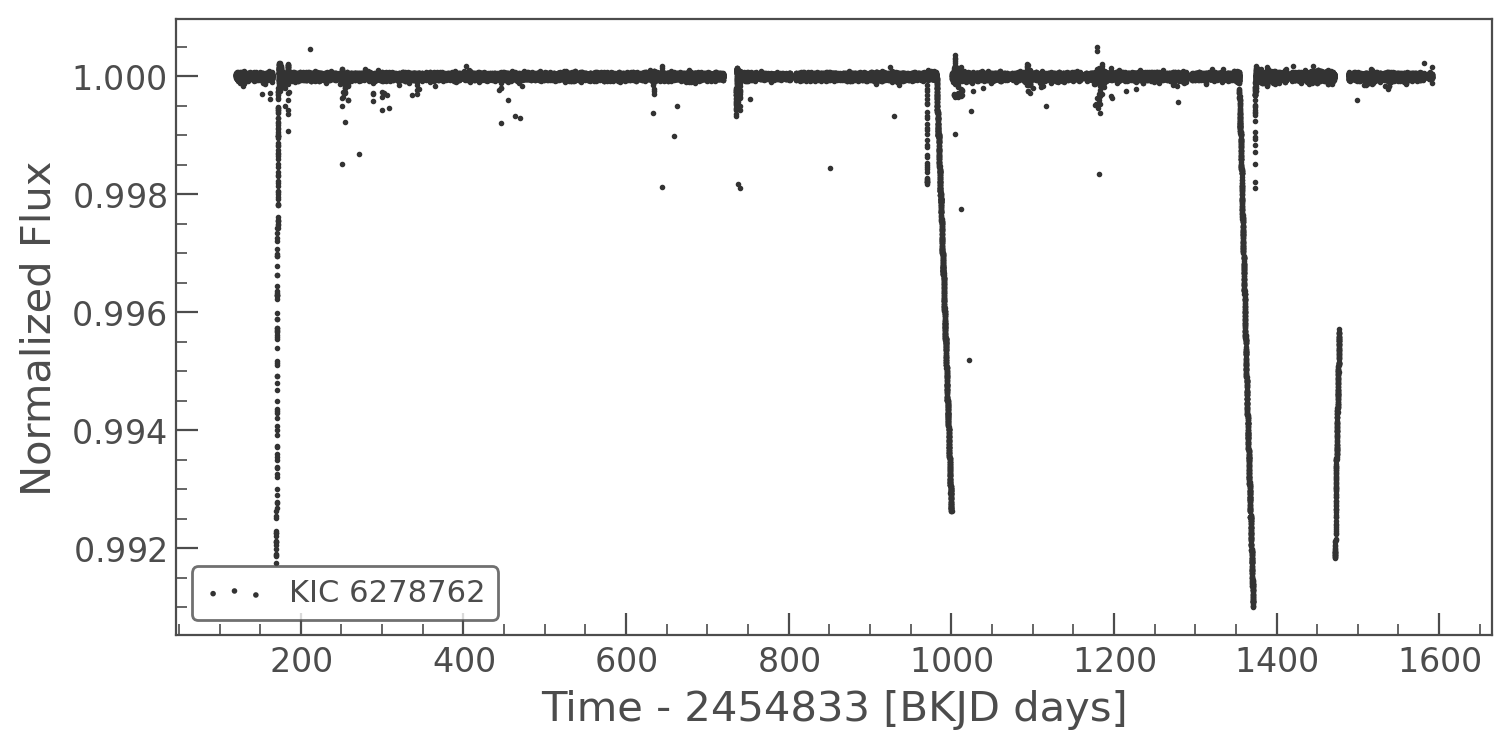

In [144]:
flat_lc.scatter()

In [152]:
np.median(lc.flux) - 5 * lc.flux.std()

<Quantity 0.99877309>

In [147]:
(lc.flux < 0.9995).sum()

168

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

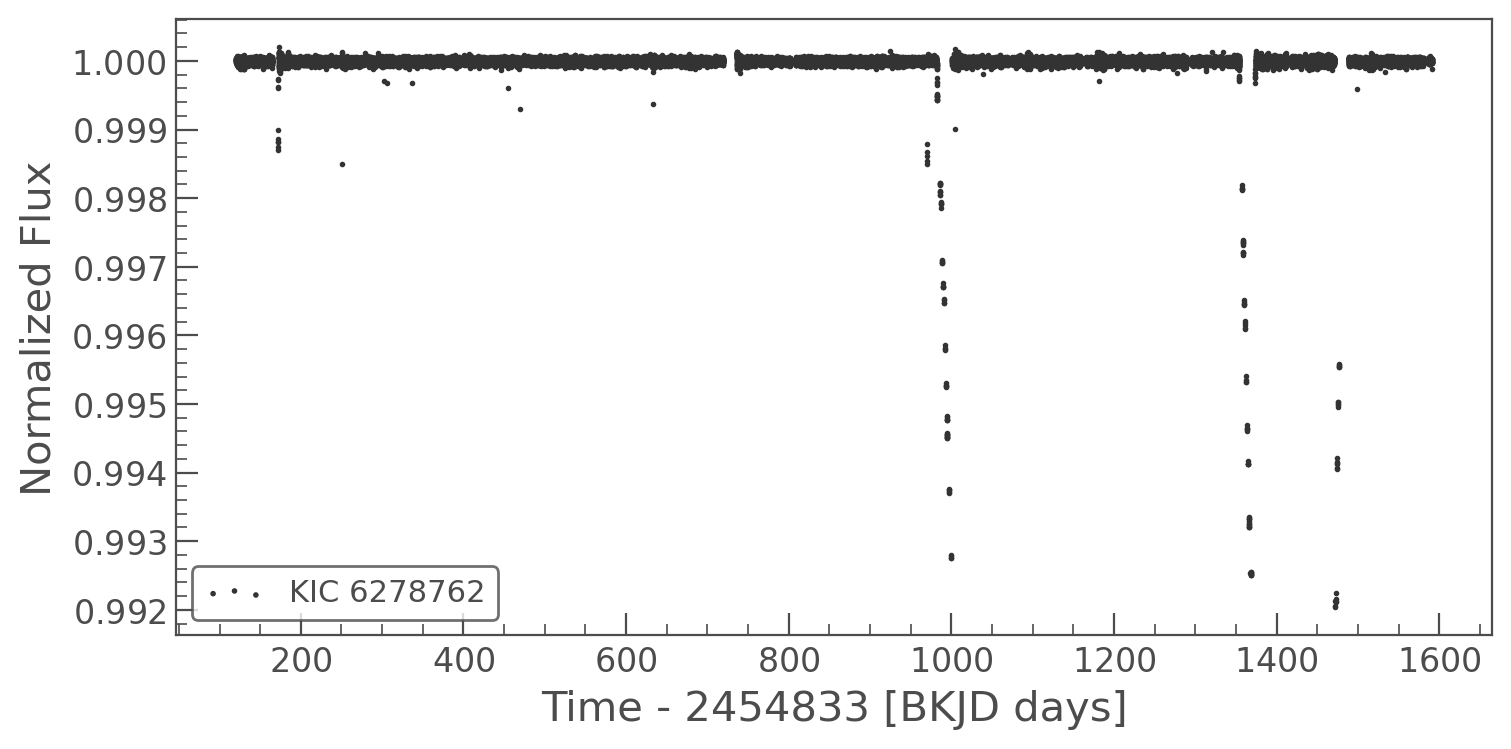

In [143]:
lc.scatter()

## Folded lightcurves

Now we can try folding the lightkurves at the different planet periods

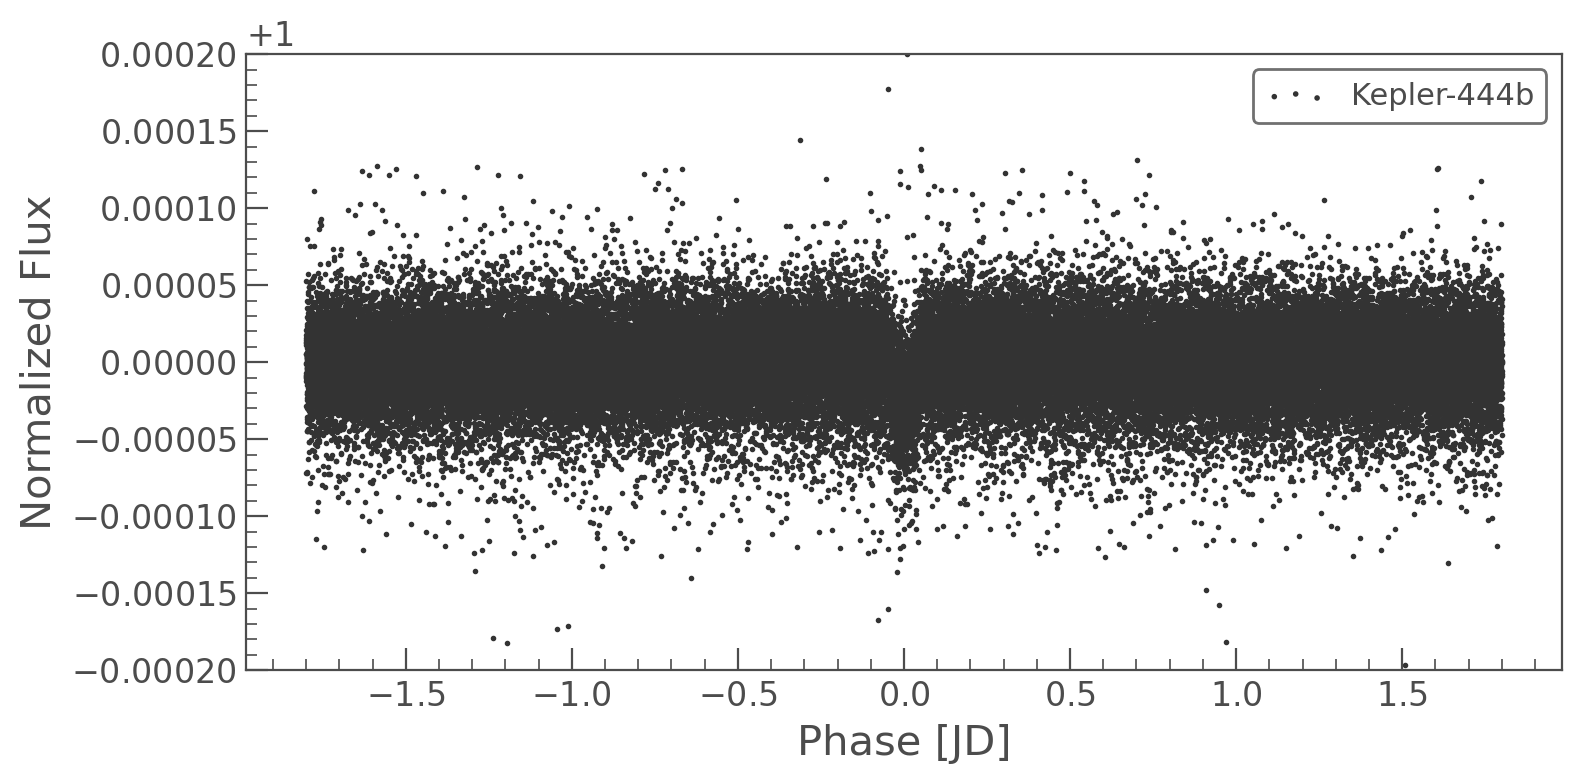

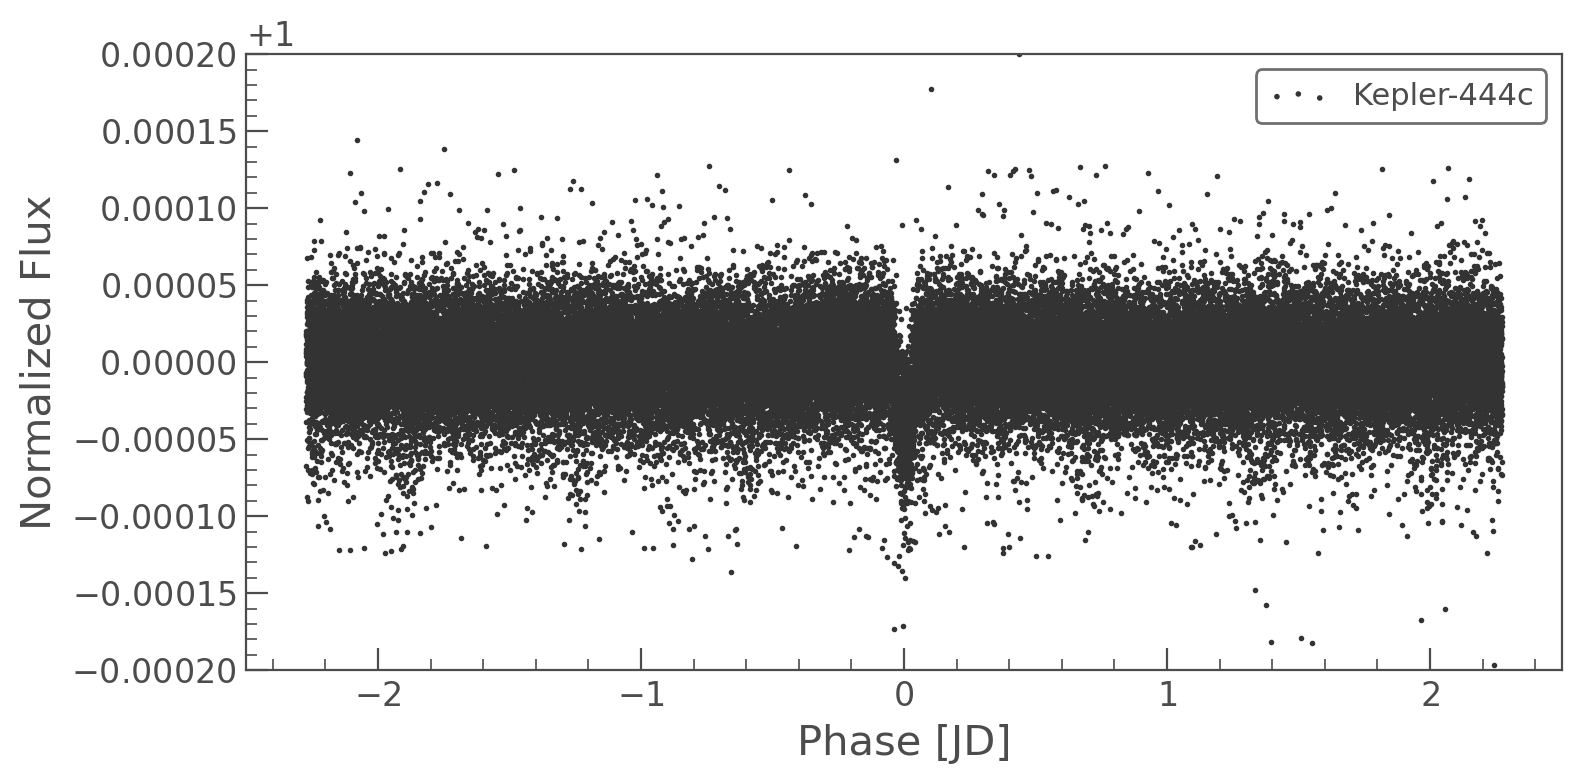

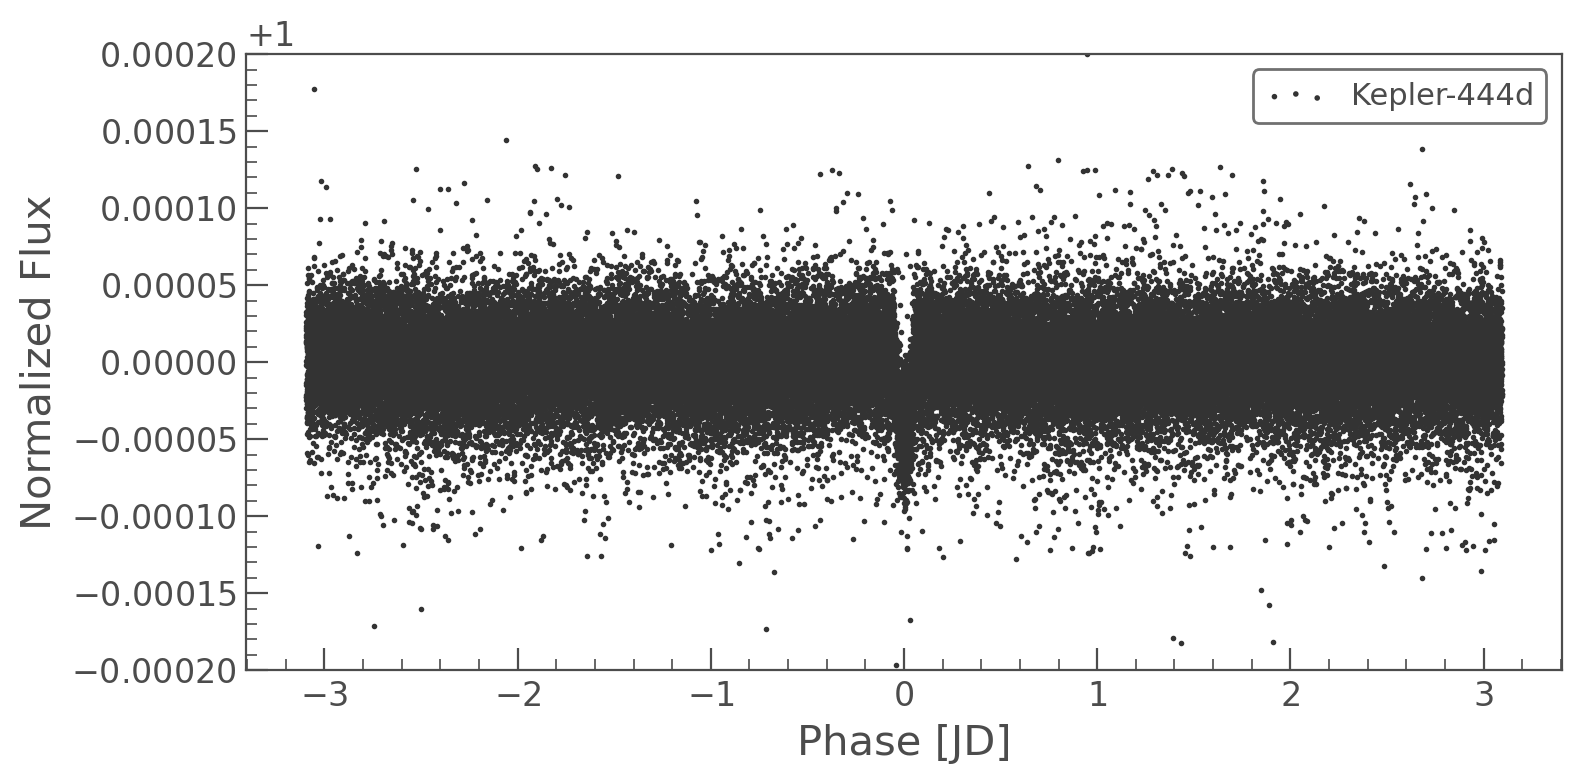

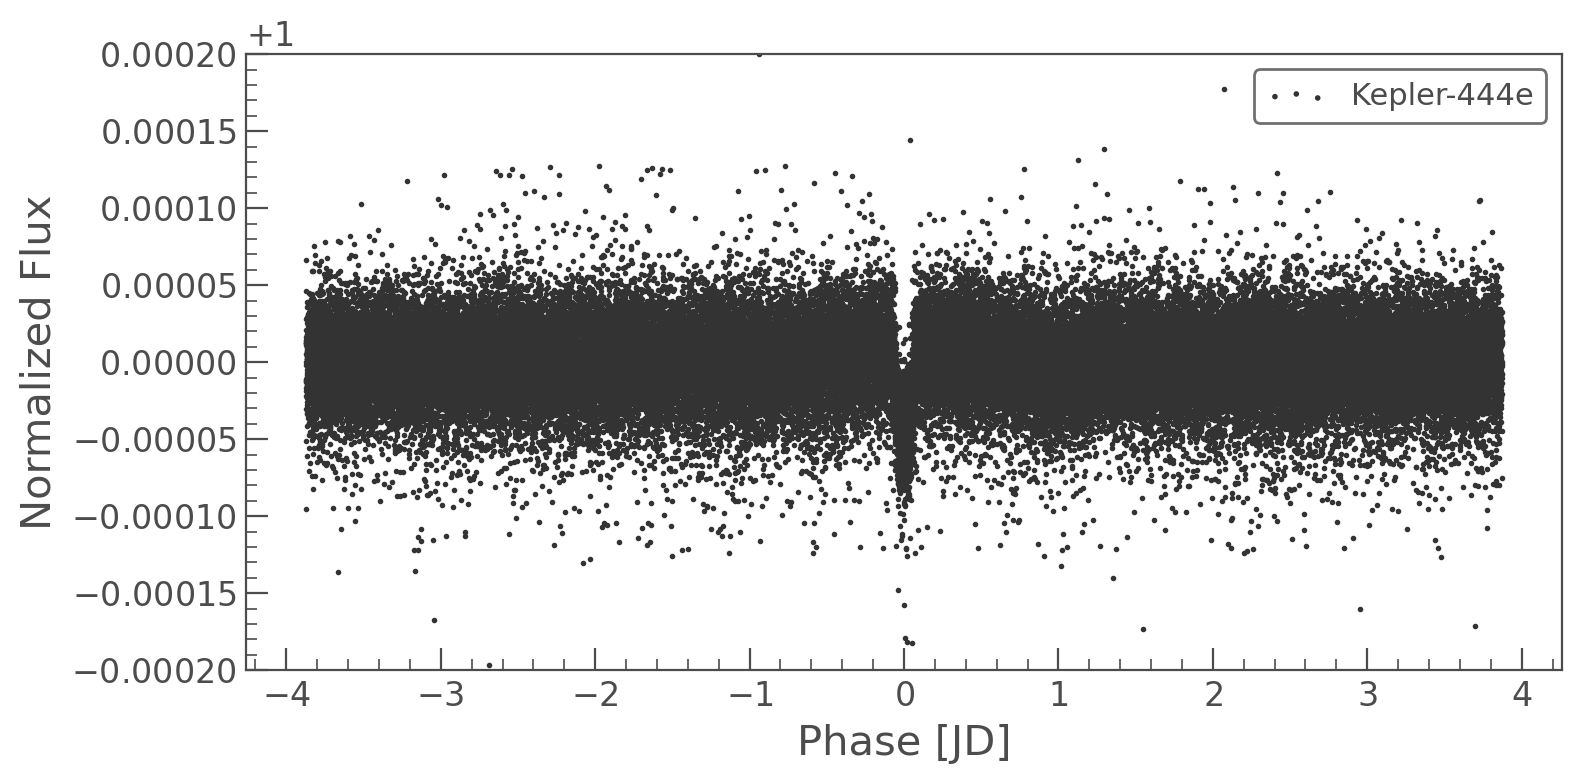

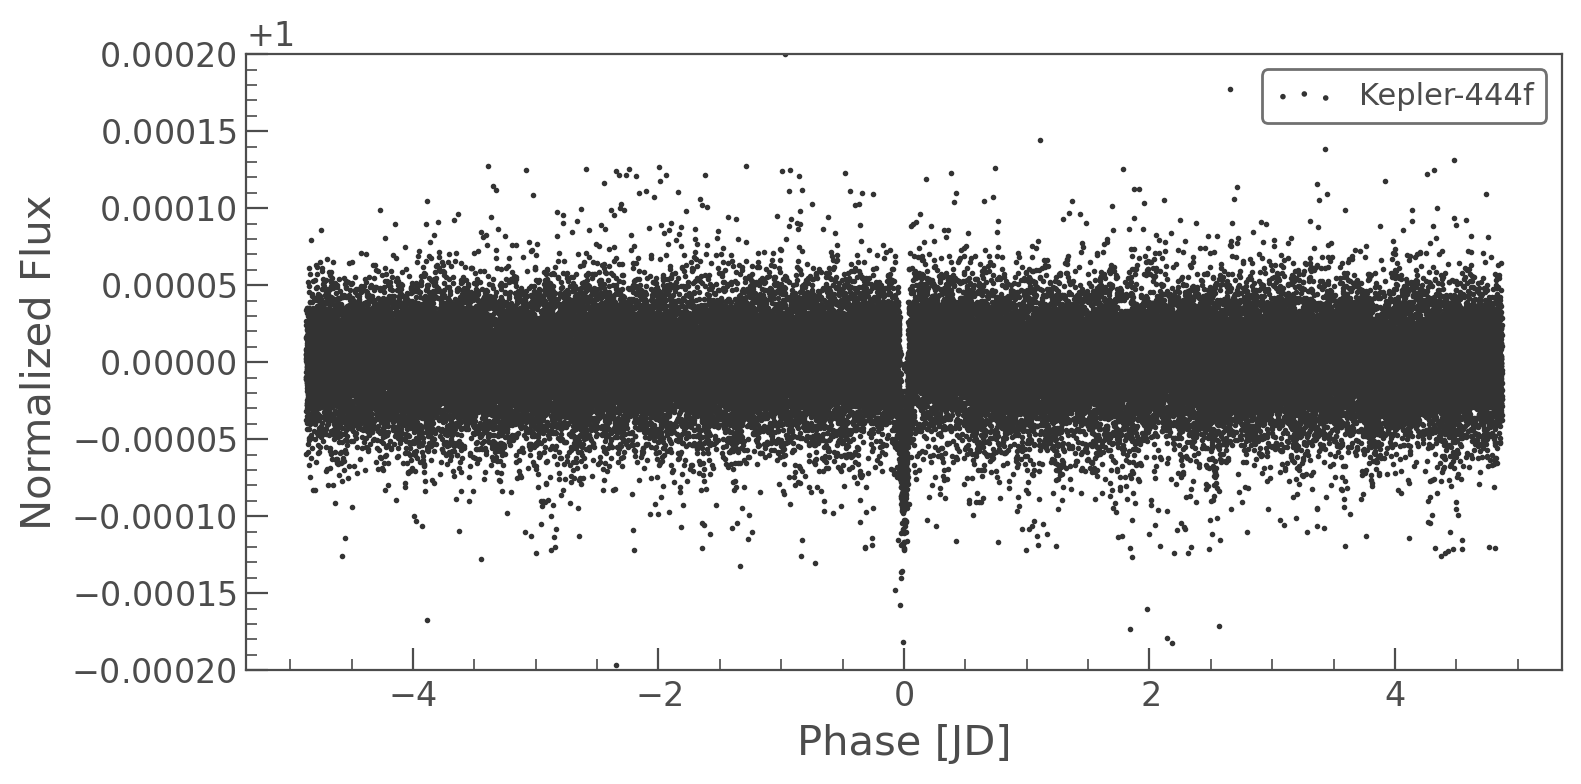

In [138]:
for planet in planets:
    ax = lc.fold(period=planet_parameters[planet]["period"],
                 epoch_time=planet_parameters[planet]["t0"].bkjd).scatter(label=f"Kepler-444{planet}")    
    ax.set_ylim(1 - 0.0002, 1 + 0.0002)

# Now to fit things

In [139]:
import pymc3 as pm
import pymc3_ext as pmx

periods = [planet_parameters[p]["period"].value for p in planet_parameters]
t0s = [planet_parameters[p]["t0"].bkjd for p in planet_parameters]
radii = [planet_parameters[p]["radius"] for p in planet_parameters]

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=1.0, sd=1.0)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=len(t0s))

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=len(periods))
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening parameters
    limb_dark = xo.distributions.QuadLimbDark("u")

    r = pm.Uniform(
        "r", lower=0.001, upper=0.01, shape=len(periods), testval=radii
    )
    b = xo.distributions.ImpactParameter(
        "b", ror=r, shape=len(periods), testval=np.random.rand(len(periods))
    )

    # fix stellar density across the stars
    log_rho_star = pm.Normal("log_rho_star",
                             mu=np.log10(star_parameters["rho"].to(u.g / u.cm**3).value), sd=1)
    rho_star = pm.Deterministic("rho_star", 10**(log_rho_star))

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b, rho_star=rho_star)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(limb_dark[0], limb_dark[1]).get_light_curve(
        orbit=orbit, r=r, t=lc["time"].value
    )
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting purposes
    pm.Deterministic("light_curves", light_curves)

    y = lc["flux"].value

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=lc["flux_err"].value, observed=y)

    # Fit for the maximum a posteriori parameters given the simulated dataset
    map_soln = pmx.optimize(start=model.test_point)

INFO (theano.gof.compilelock): Refreshing lock /home/tom/.theano/compiledir_Linux-5.19--generic-x86_64-with-glibc2.35-x86_64-3.9.16-64/lock_dir/lock


message: Desired error not necessarily achieved due to precision loss.
logp: -15265880.837589968 -> -14978776.199721172


In [140]:
map_soln

{'mean': array(1.00000068),
 't0': array([133.25860723, 131.53437402, 134.7856271 , 135.08970171,
        134.90611339]),
 'logP': array([1.28096586, 1.51421106, 1.82284281, 2.04685468, 2.27626549]),
 'u_quadlimbdark__': array([10.9962726 ,  2.49921689]),
 'r_interval__': array([ 2.74823587, 10.32112014, 13.16163395,  6.7251519 , -0.28176466]),
 'b_impact__': array([ -2.60699058, -56.20963912,  -0.09647217,  -0.13465291,
         -1.63181256]),
 'log_rho_star': array(0.15511589),
 'period': array([3.60011525, 4.54583334, 6.18942884, 7.74350697, 9.74023734]),
 'u': array([ 1.84815831, -0.8481667 ]),
 'r': array([0.00945832, 0.0099997 , 0.00999998, 0.00998921, 0.00487019]),
 'b': array([6.93395622e-02, 3.91548125e-25, 4.80659644e-01, 4.71046388e-01,
        1.64378887e-01]),
 'rho_star': array(1.42927531),
 'light_curves': array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
     

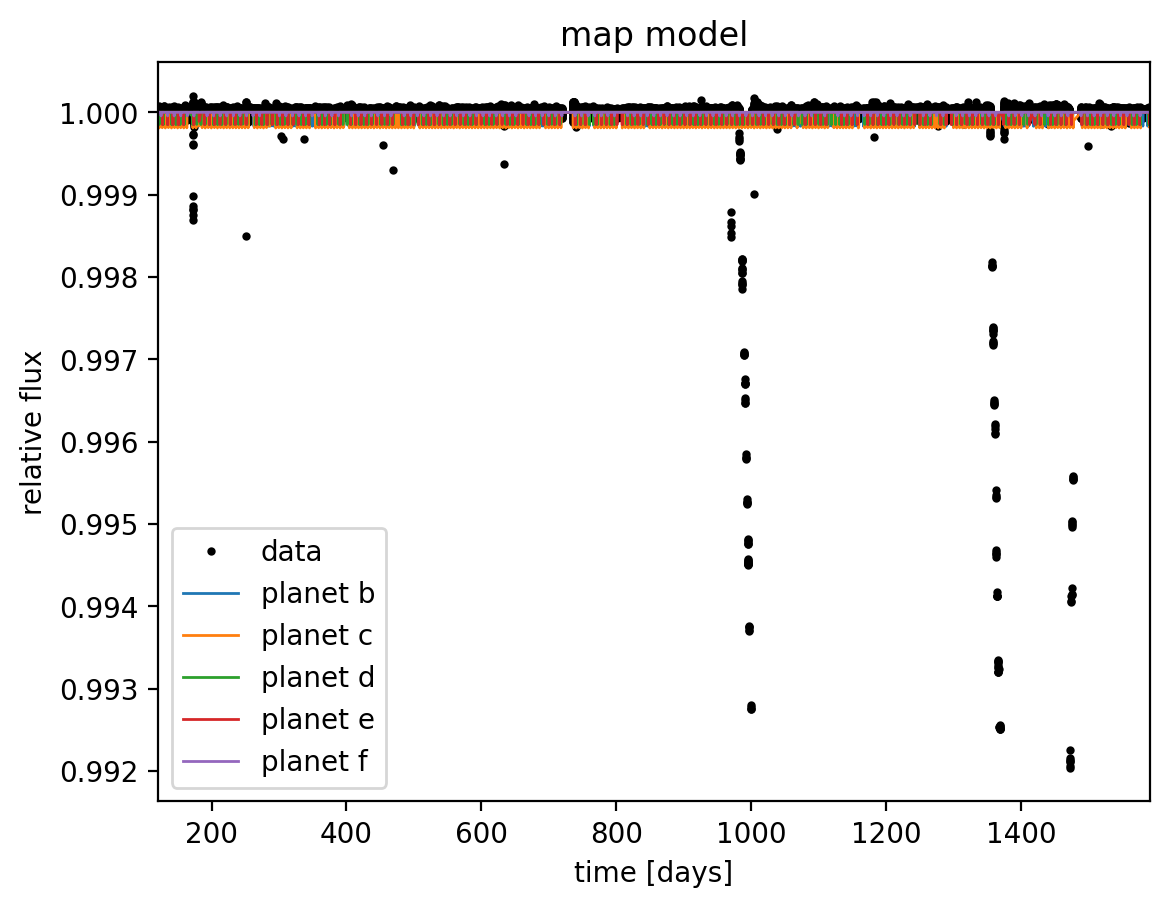

In [141]:
t = lc["time"].value
plt.plot(t, y, ".k", ms=4, label="data")
for i, l in enumerate("bcdef"):
    plt.plot(
        t, map_soln["light_curves"][:, i] + 1, lw=1, label="planet {0}".format(l)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

In [ ]:
with model:
    trace = pmx.sample(
        tune=10,
        draws=10,
        start=map_soln,
        cores=6,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
    )

Sampling 2 chains for 10 tune and 10 draw iterations (20 + 20 draws total) took 14 seconds.
/home/tomwagg/anaconda3/envs/radius-gap/lib/python3.10/site-packages/pymc3/sampling.py:628: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn(


In [ ]:
trace.posterior["light_curves"]

<xarray.DataArray 'light_curves' (chain: 2, draw: 10,
                                  light_curves_dim_0: 62915,
                                  light_curves_dim_1: 5)>
array([[[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
...
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]]])
Coordinates:
  * chain               (chain) int64 0 1
  * draw                (draw) int64 0 1 2 3 4 5 6 7 8 9
  * light_curves_dim_0  (light_curves_dim_0) int64 0 1 2 3 ... 62912 62913 62914
  * light_curves_dim_1  (light_curves_dim_1) int64 0 1 2 3 4

Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


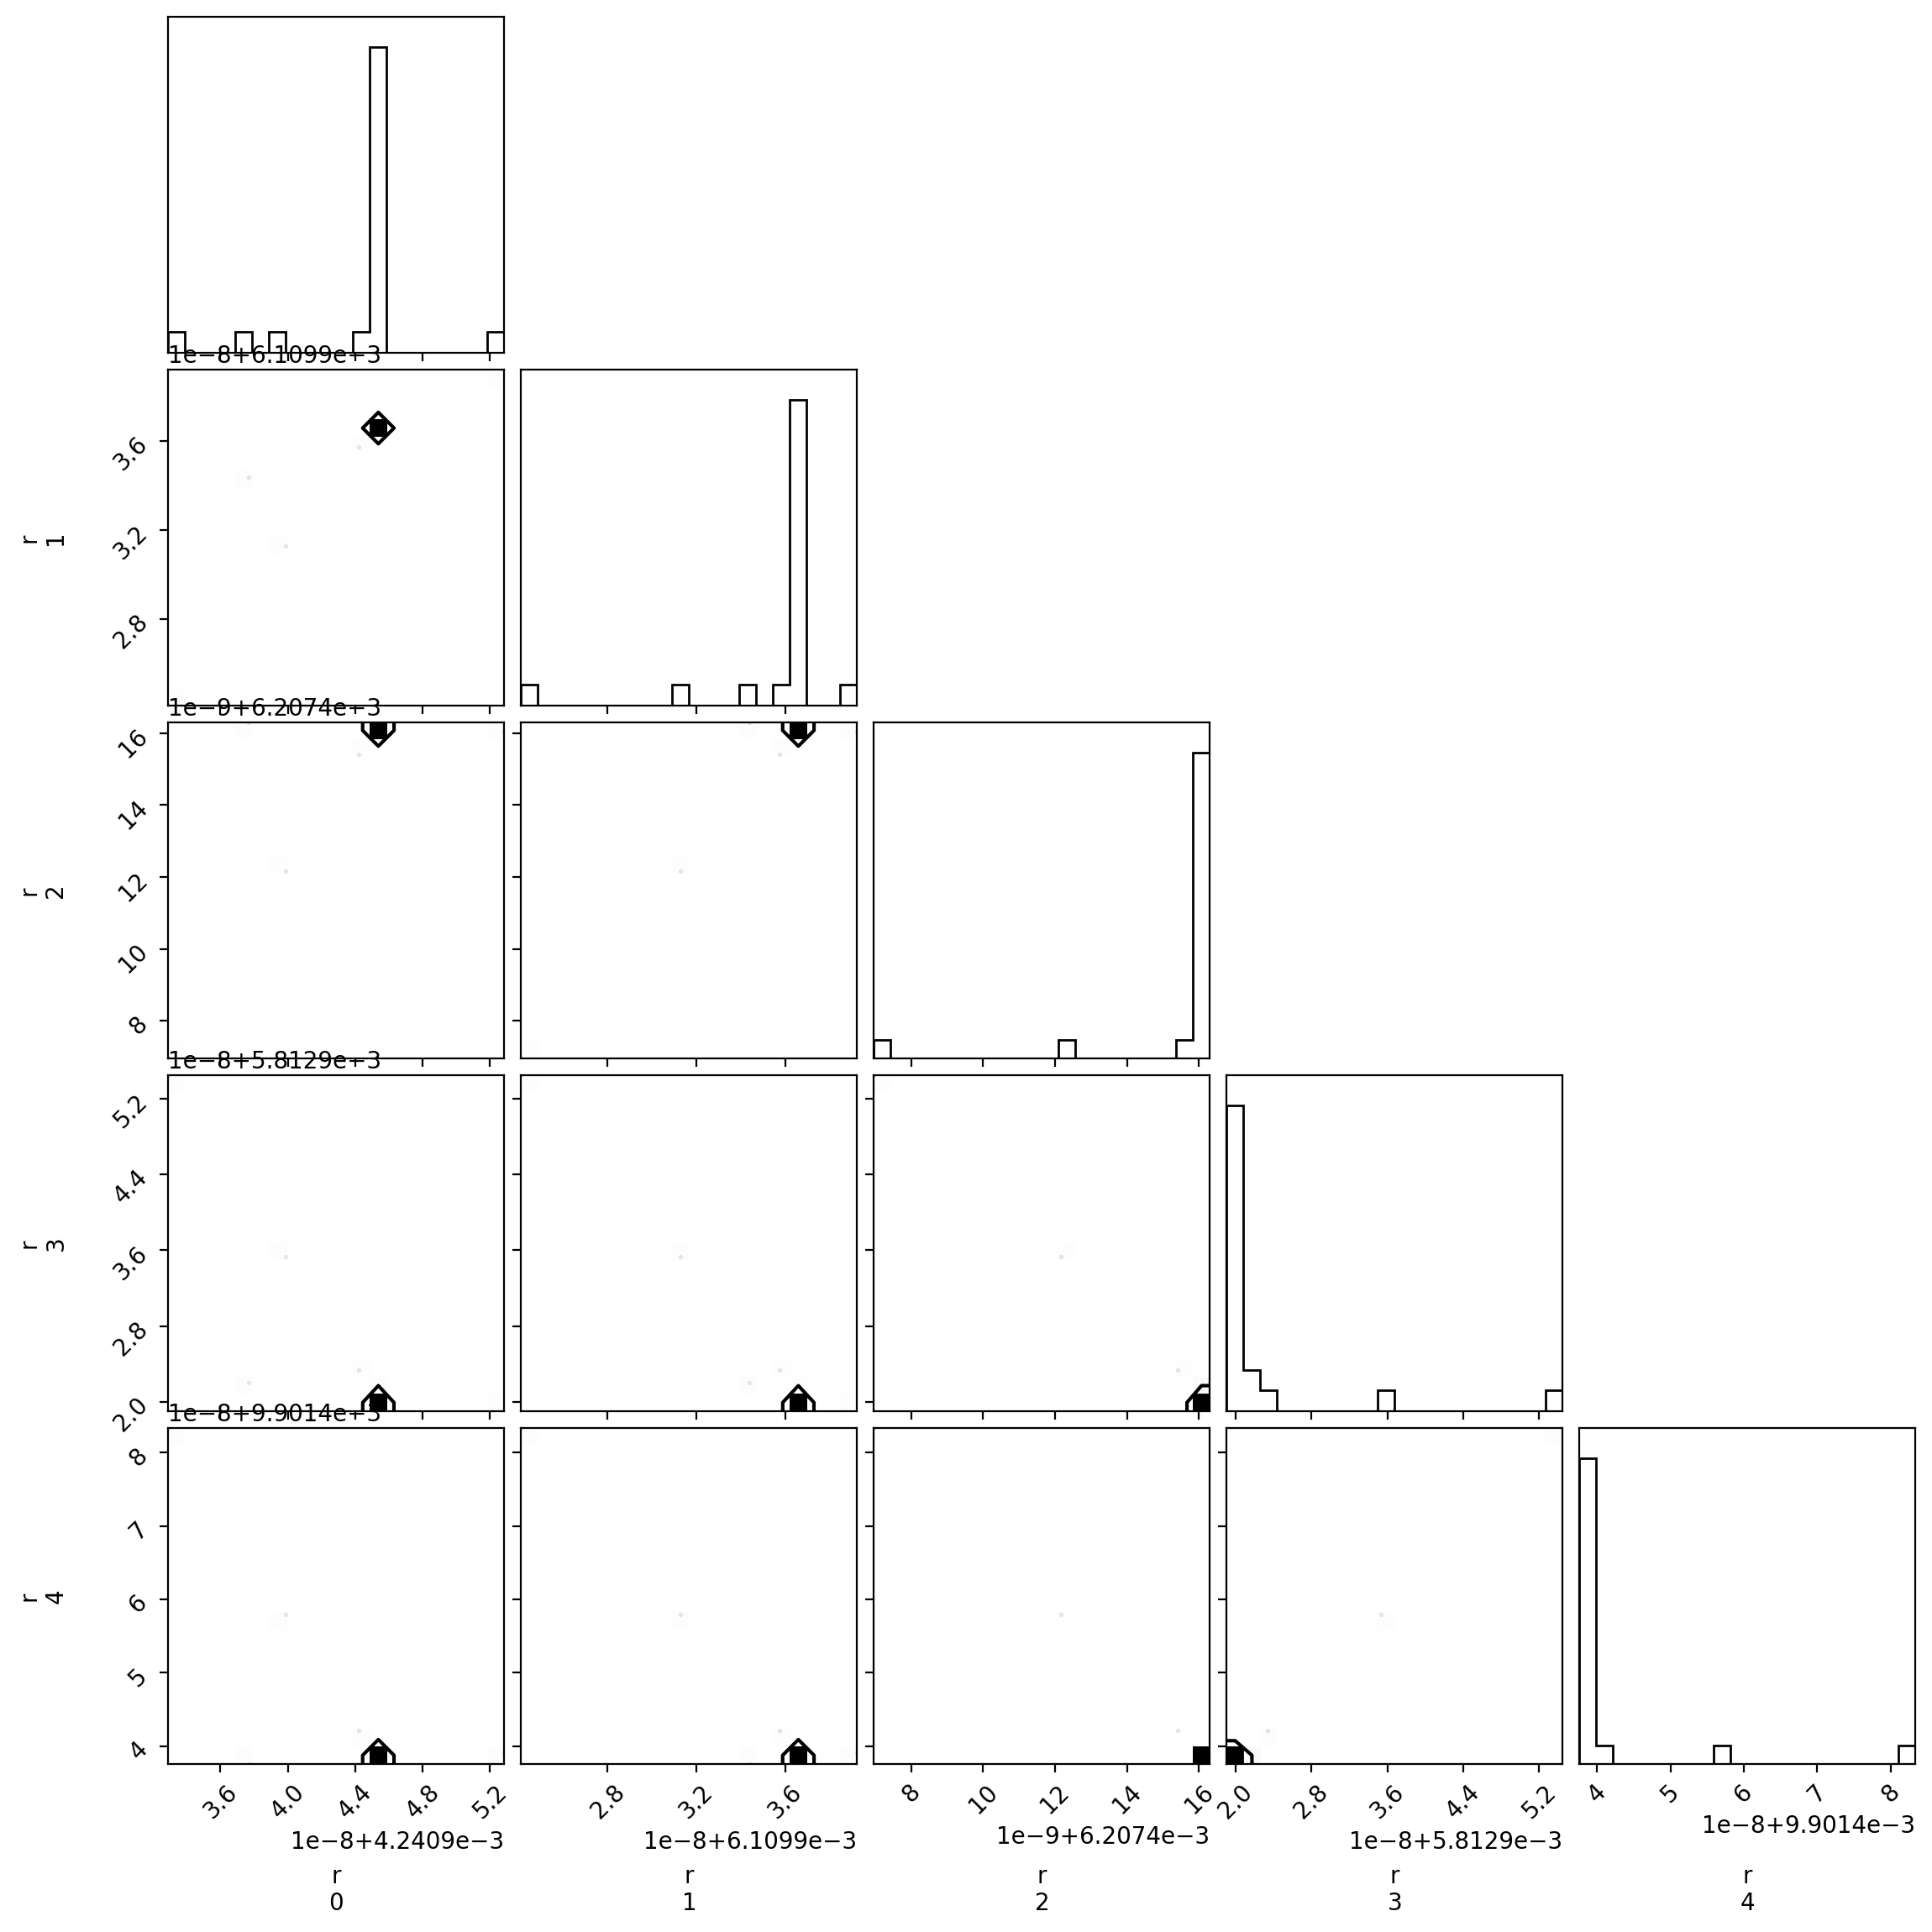

In [ ]:
import corner

truth = dict(
    zip(
        ["r"],
        pmx.eval_in_model([period, r], model.test_point, model=model),
    )
)
_ = corner.corner(
    trace,
    var_names=["r"],
    truths=truth,
)

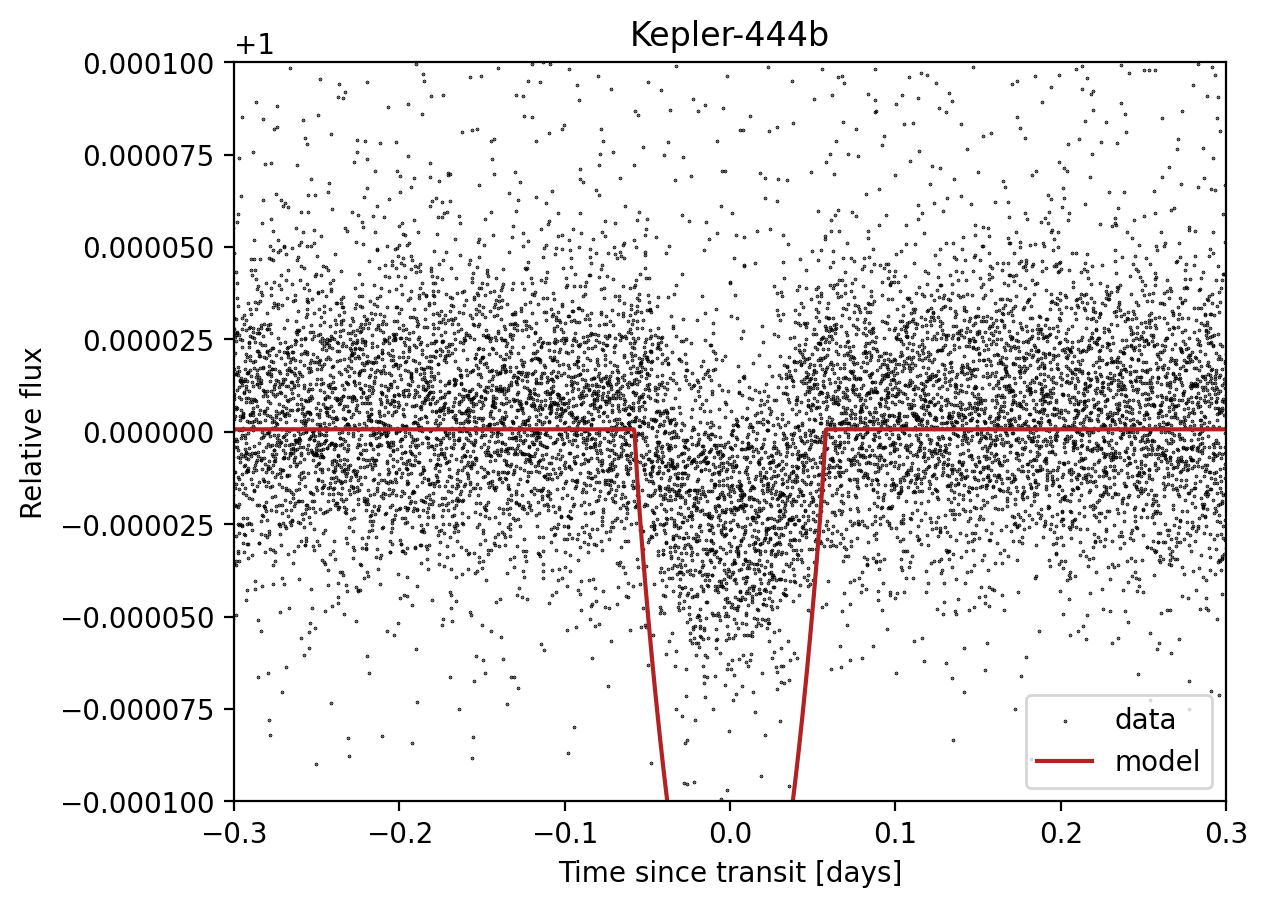

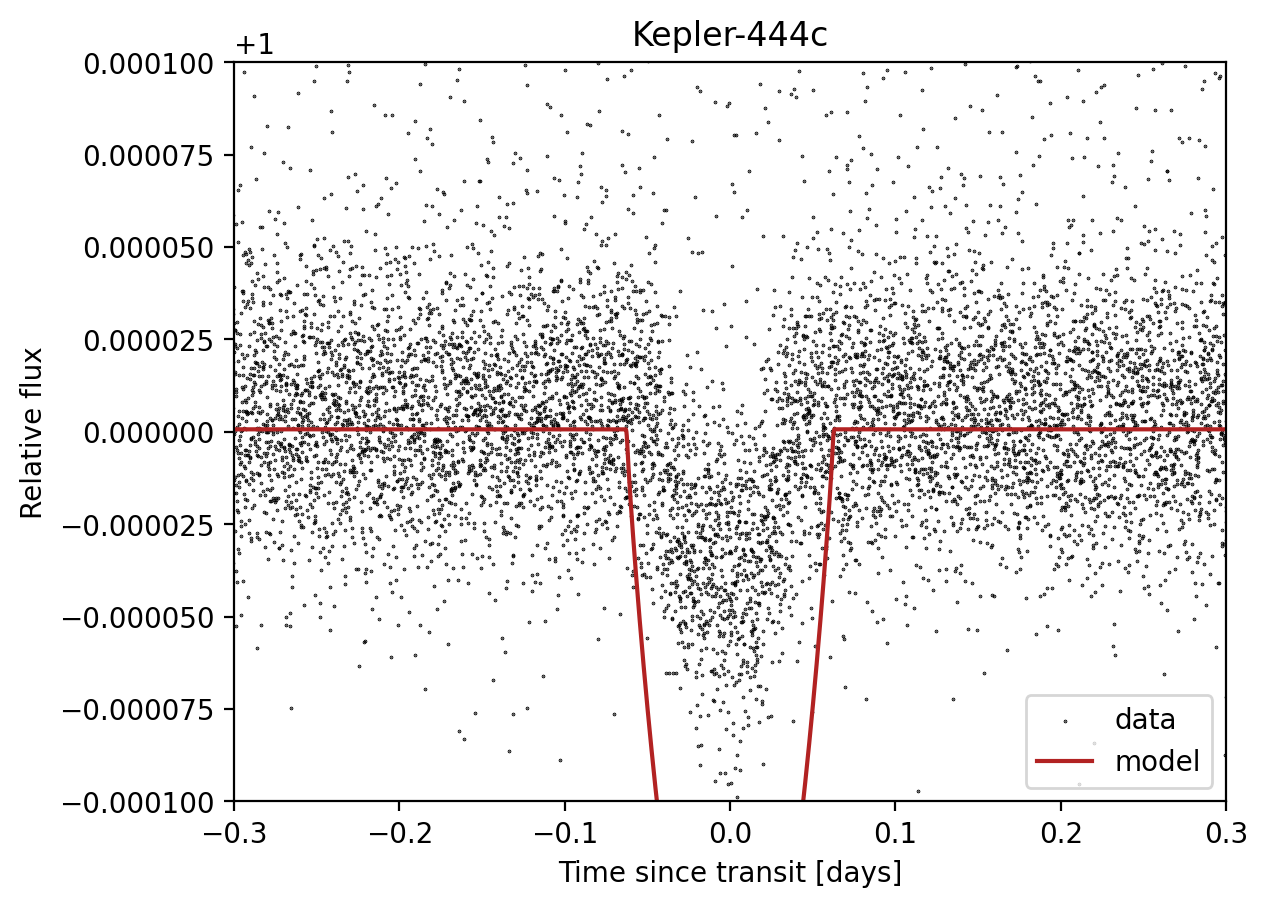

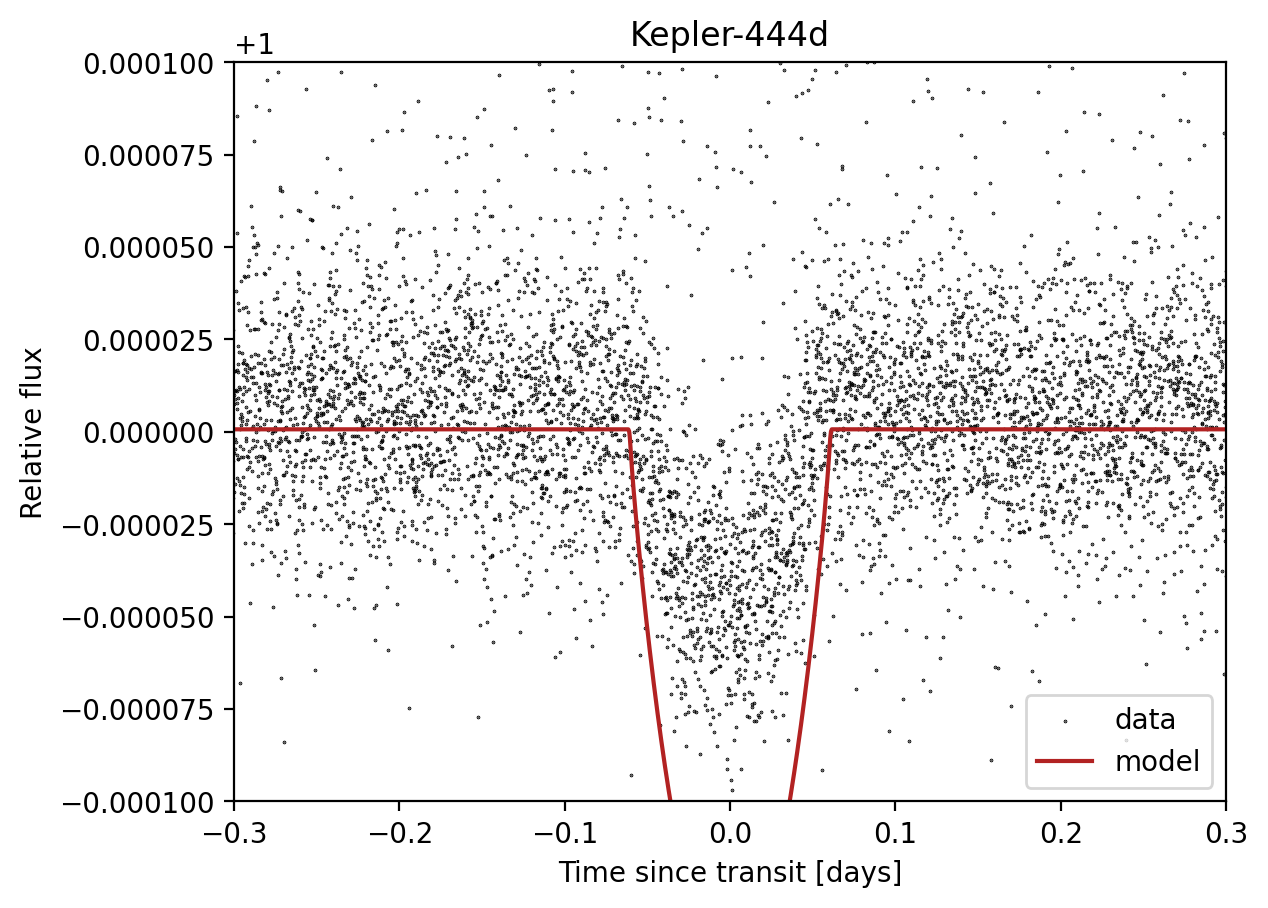

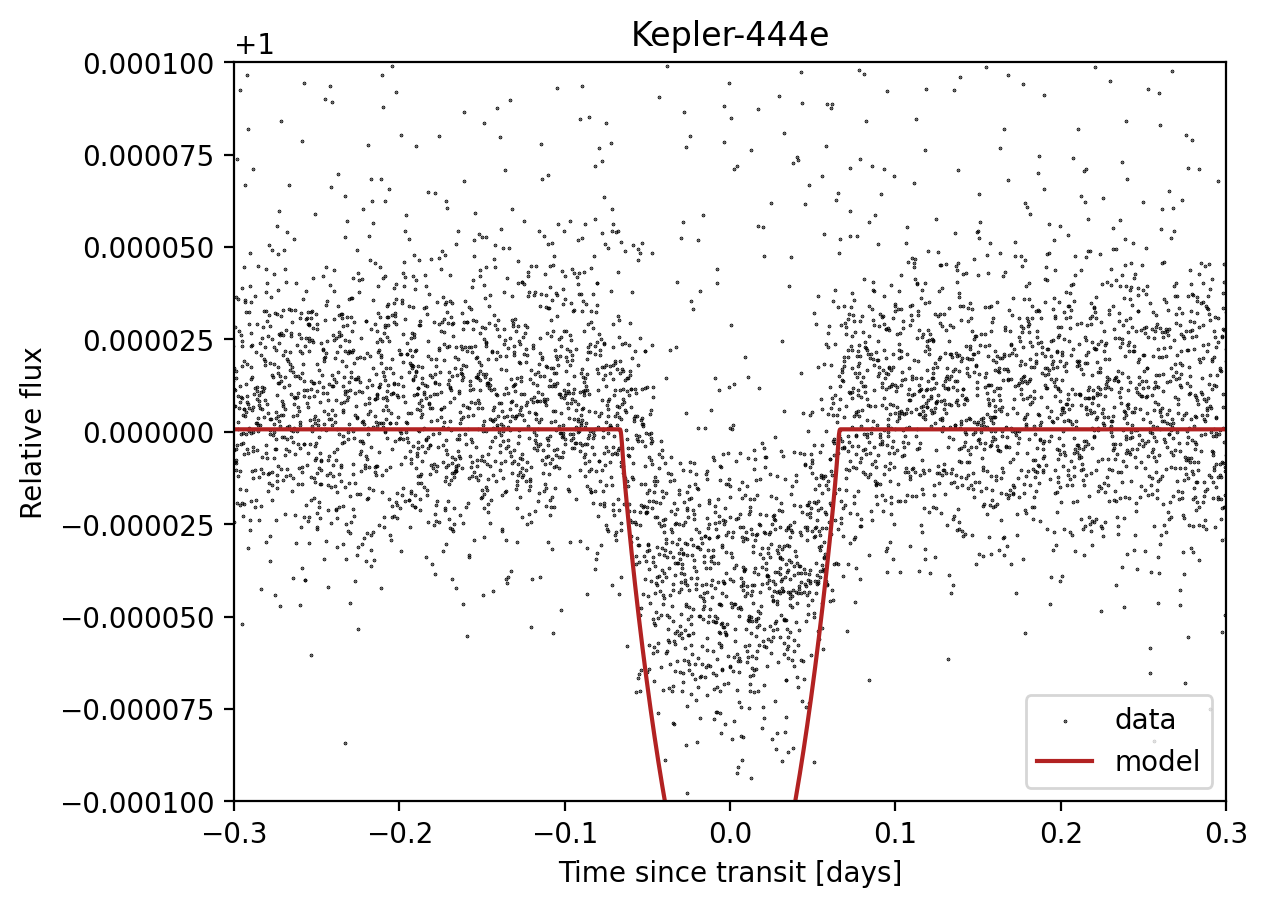

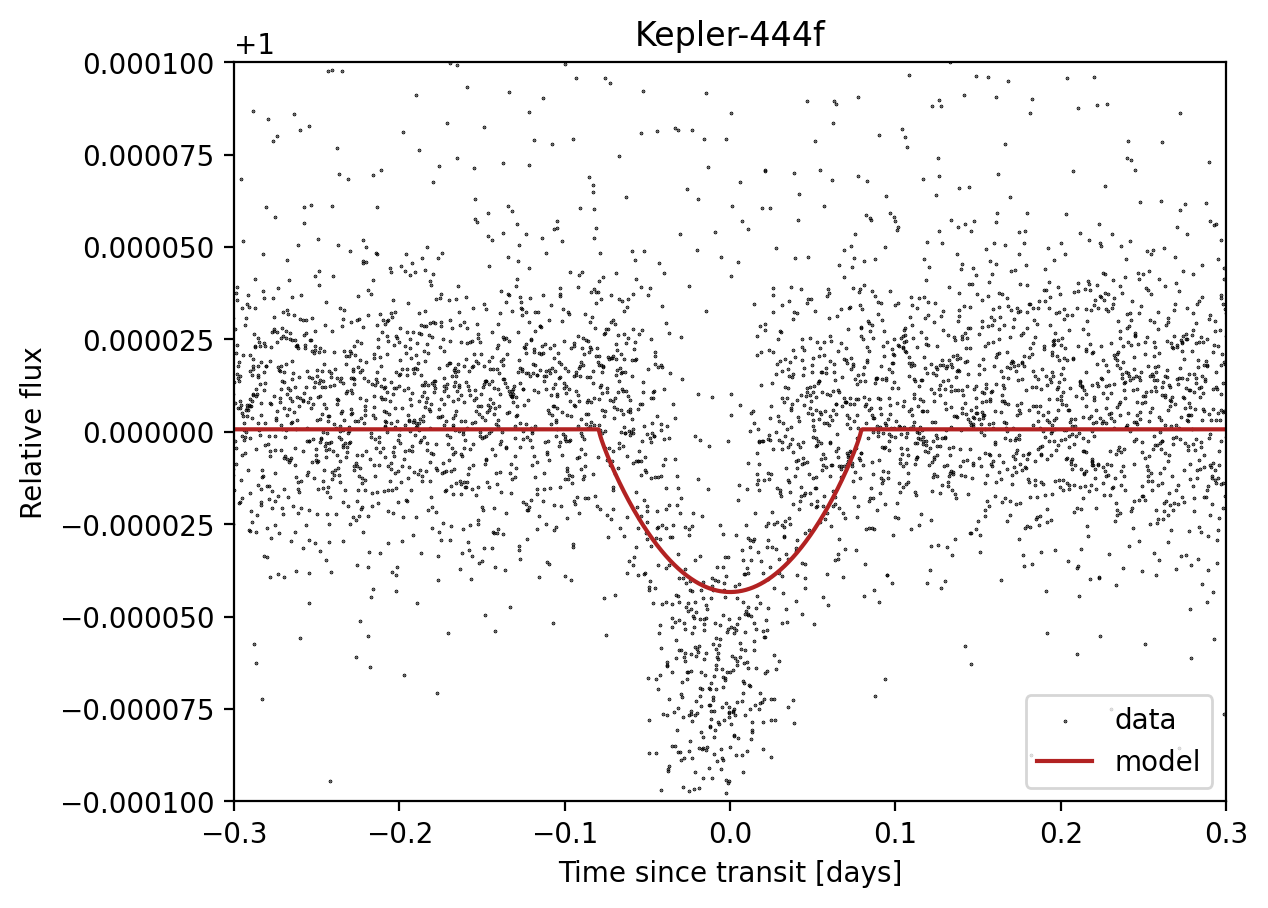

In [142]:
planetletters = "bcdef"
for n, letter in enumerate(planetletters):
    plt.figure()

    p = map_soln["period"][n]
    t0 = map_soln["t0"][n]

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    lcs = map_soln["light_curves"]
    other = lcs[:, [ind for ind in range(len(planetletters)) if ind != n]].sum(axis=1)

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.scatter(
        x_fold, y - other, label="data", zorder=-1000, s=0.1, color="black"
    )

    # Plot the folded model within 0.3 days of the transit
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = lcs[inds, n] + map_soln["mean"]
    plt.plot(x_fold[inds], pred, color="firebrick", label="model")

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("Time since transit [days]")
    plt.ylabel("Relative flux")
    plt.title(f"Kepler-444{letter}")
    plt.xlim(-0.3, 0.3)
    plt.ylim(1 - 1e-4, 1 + 1e-4)

ValueError: x and y must have same first dimension, but have shapes (10544,) and (2, 10, 10544)

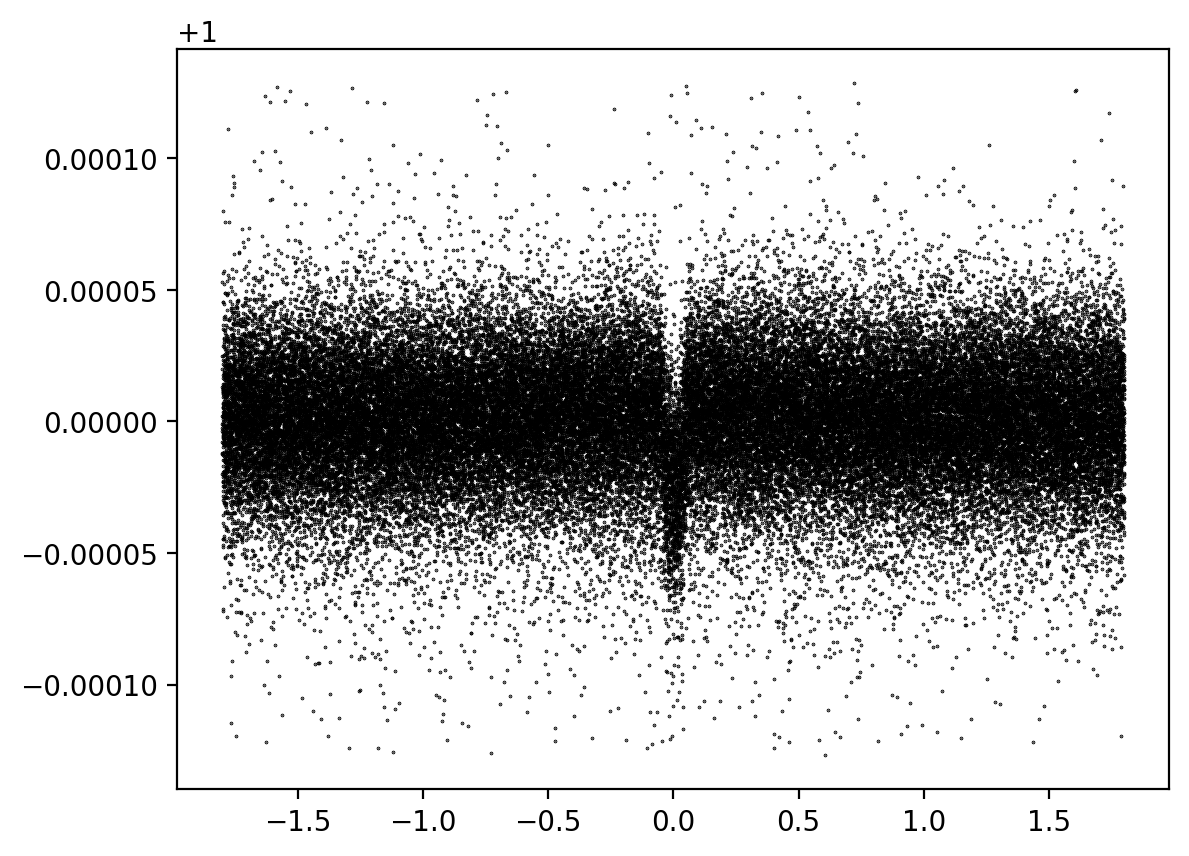

In [ ]:
for n, letter in enumerate("bcdef"):
    plt.figure()

    # Get the posterior median orbital parameters
    period_trace = trace.posterior["period"].values[:, :, n]
    p = np.median(period_trace)
    t0 = np.median(trace.posterior["t0"].values[:, :, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    lcs = trace.posterior["light_curves"].values
    other = np.median(lcs[:, :, :, (n + 1) % 2], axis=(0, 1))

    # Plot the folded data
    x_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
    plt.scatter(
        x_fold, y - other, label="data", zorder=-1000, s=0.1, color="black"
    )

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = lcs[:, :, inds, n] + trace.posterior["mean"].values[:, :, None]
    pred = np.median(pred, axis=(0, 1))
    plt.plot(x_fold[inds], pred, color="firebrick", label="model")

    # Annotate the plot with the planet's period
    # txt = "period = {0:.4f} +/- {1:.4f} d".format(
    #     np.mean(period_trace), np.std(period_trace)
    # )
    # plt.annotate(
    #     txt,
    #     (0, 0),
    #     xycoords="axes fraction",
    #     xytext=(5, 5),
    #     textcoords="offset points",
    #     ha="left",
    #     va="bottom",
    #     fontsize=12,
    # )

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5 * p, 0.5 * p)
    plt.xlabel("Time since transit [days]")
    plt.ylabel("Relative flux")
    plt.title(f"Kepler-444{letter}")
    plt.xlim(-0.3, 0.3)

In [ ]:
map_soln

{'mean': array(1.00000258),
 't0': array([133.2592071 , 131.52259556, 134.78405762, 135.0924038 ,
        134.87796413]),
 'logP': array([1.28096534, 1.51422307, 1.82284166, 2.04685383, 2.27629252]),
 'u_quadlimbdark__': array([4.04208469, 0.41296919]),
 'r_interval__': array([-3.38597016, -2.91093752, -2.89100199, -2.97397892, -2.31469132]),
 'b_impact__': array([-0.54144669,  0.80877206,  0.49245535, -0.52024832,  1.73962455]),
 'log_rho_star': array(0.29461426),
 'period': array([3.6001134 , 4.54588794, 6.1894217 , 7.74350034, 9.74050063]),
 'u': array([ 1.19316832, -0.20183476]),
 'r': array([0.00424095, 0.00610994, 0.00620742, 0.00581292, 0.00990144]),
 'b': array([0.36941115, 0.69607492, 0.62453753, 0.37496119, 0.85906192]),
 'rho_star': array(1.9706716),
 'light_curves': array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])}

<AxesSubplot: title={'center': 'Target ID: 6278762, Cadence: 61886'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

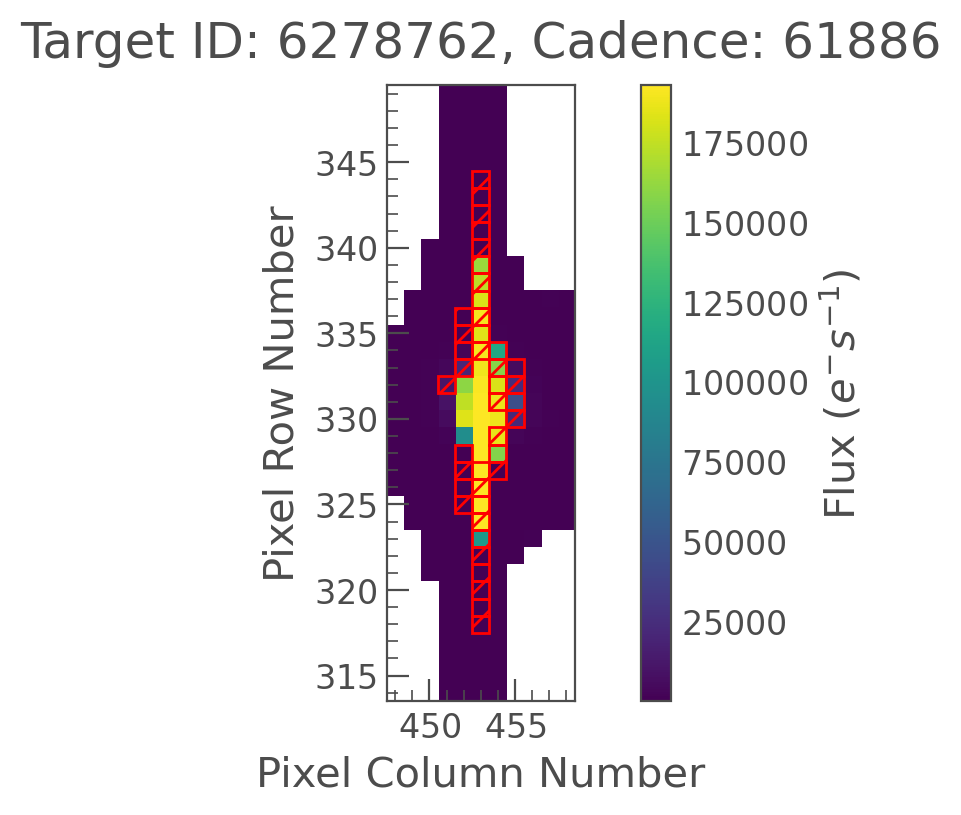

In [ ]:
tpfs[15].plot(aperture_mask="pipeline")